# Шаг 0. Импорт библиотек и настройка рабочего окружения

# В этом ноутбуке мы проведём RFM-анализ (Recency, Frequency, Monetary) — один из ключевых инструментов сегментации клиентов.
# Цель: разделить клиентов на группы по их покупательскому поведению для улучшения маркетинговых стратегий.

In [ ]:
# Устанавливаем библиотеки для визуализации деревьев решений
!pip install pydot
!pip install pydotplus

# Шаг 1. Загрузка данных, анализ пропущенных значений и предварительная очистка

# На этом этапе:
# - Загрузим датасет Online Retail II
# - Изучим структуру данных
# - Проанализируем и обработаем пропущенные значения (NaN)

In [ ]:
# Загружаем датасет онлайн-ритейла
# Датасет содержит транзакции британского интернет-магазина за период 2009-2011 гг.
df = pd.read_csv('../input/online-retail-ii-uci/online_retail_II.csv')

In [ ]:
# Просматриваем первые 5 строк датасета для понимания структуры данных
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# Получаем информацию о типах данных и количестве непустых значений
# Это поможет понять, с какими данными мы работаем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
# Статистическое описание числовых колонок
# Обратите внимание на отрицательные значения в Quantity — это возвраты!
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### В датасете 3 числовые колонки. Однако колонка Customer ID должна рассматриваться как категориальная переменная, поскольку каждый ID представляет одного клиента и не несёт числового смысла. Остальные 5 колонок также являются категориальными.

**Структура колонок:**
- `Invoice` — номер счёта/заказа
- `StockCode` — код товара
- `Description` — описание товара
- `Quantity` — количество единиц товара
- `InvoiceDate` — дата и время заказа
- `Price` — цена за единицу товара
- `Customer ID` — уникальный идентификатор клиента
- `Country` — страна клиента


#### Проверим пропущенные значения (NaN) и их распределение по колонкам

Анализ пропущенных значений критически важен для понимания качества данных и выбора стратегии их обработки.

In [ ]:
# Подсчитываем количество пропущенных значений по каждой колонке
null_df = df.isnull().sum().reset_index()
null_df.rename(columns={0: 'nan values', 'index': 'column_name'}, inplace=True)

# Вычисляем процент пропущенных значений
total_len_df = df.shape[0]
null_df['nan percentage'] = round(null_df['nan values'] / total_len_df * 100, 2)

# Результат: Customer ID имеет 22.77% пропусков — это клиенты без регистрации
print(null_df)

   column_name  nan values  nan percentage
0      Invoice           0            0.00
1    StockCode           0            0.00
2  Description        4382            0.41
3     Quantity           0            0.00
4  InvoiceDate           0            0.00
5        Price           0            0.00
6  Customer ID      243007           22.77
7      Country           0            0.00


#### Большинство пропущенных значений находится в колонке Customer ID. Поскольку нас интересует сегментация именно клиентов, у нас нет другого выбора, кроме как удалить строки с пропущенными ID.

#### 0.41% пропусков в описании товаров — некритичное количество, поэтому мы можем безболезненно удалить все строки с NaN из датафрейма.

**Важно:** Около 23% транзакций совершены незарегистрированными пользователями (гостями). Для полноценного RFM-анализа эти данные, к сожалению, нельзя использовать.

In [ ]:
# Удаляем все строки с пропущенными значениями
df.dropna(inplace=True)
# Сбрасываем индексы для корректной работы с датафреймом
df = df.reset_index(drop=True)

#### В описании датасета указано, что отменённые заказы начинаются с префикса "C" в номере счёта. Давайте исключим отмены из первичного расчёта метрик.

Отменённые заказы искажают картину реального потребительского поведения, поэтому для чистоты RFM-анализа их лучше убрать.

In [ ]:
# Проверяем несколько строк с отменёнными заказами
# Обратите внимание: количество (Quantity) имеет отрицательное значение при отмене
df[df['Invoice'].str.contains('C')].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [ ]:
# Находим последнюю дату в датасете — понадобится для расчёта Recency
# Recency = сколько дней прошло с последней покупки клиента
df['InvoiceDate'].max()

'2011-12-09 12:50:00'

#### Как видим, отменённые заказы также помечены знаком минус в колонке количества. Теперь мы можем удалить все строки, связанные с отменёнными заказами. Это позволит провести сегментацию клиентов по давности, частоте и сумме покупок без учёта отмен.

#### Отменённые заказы требуют отдельного анализа, как и клиенты, совершающие отмены. Это можно сделать в рамках отдельной задачи по поиску закономерностей в отменах. Более того, может быть интересно детально изучить отмены от клиентов, принадлежащих к наиболее ценным сегментам.

**Практический совет:** Анализ отмен может выявить проблемы с качеством товаров, описанием или логистикой.

In [ ]:
# Фильтруем датасет, исключая отменённые заказы
# Символ ~ означает отрицание (NOT) — оставляем только те строки, где Invoice НЕ содержит 'C'
clean_df = df[~(df['Invoice'].str.contains('C'))]

### Теперь в датафрейме остались только НЕ отменённые заказы.

# Шаг 2. Расчёт RFM-метрик для каждого клиента

**RFM-метрики:**
- **R (Recency)** — Давность: сколько дней прошло с последней покупки
- **F (Frequency)** — Частота: количество уникальных заказов
- **M (Monetary)** — Денежная ценность: общая сумма покупок

Чем меньше R и больше F и M — тем ценнее клиент!

In [ ]:
# Создаём новую колонку Amount — сумма покупки (количество × цена)
# Это будет основой для расчёта денежной ценности клиента (Monetary)
clean_df['Amount'] = clean_df['Quantity'] * clean_df['Price']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Агрегируем метрики по каждому клиенту
customers_df = clean_df.groupby(['Customer ID']).agg(
    frequency = ('Invoice', 'nunique'),     # F: количество уникальных заказов
    last_purchase = ('InvoiceDate', 'max'), # Дата последней покупки (для расчёта R)
    amount = ('Amount', 'sum')              # M: общая сумма покупок
).reset_index()  # Преобразуем groupby объект в датафрейм

# Конвертируем дату последней покупки в формат datetime
customers_df['last_purchase'] = pd.to_datetime(customers_df['last_purchase'], format='%Y-%m-%d')

# Вычисляем Recency: разница между "сегодня" (11.12.2011 + 1 день) и датой последней покупки
# 11.12.2011 — последняя дата в датасете, поэтому используем следующий день как точку отсчёта
customers_df['recency'] = datetime(2011, 12, 11) - customers_df['last_purchase']
customers_df['recency'] = customers_df['recency'].dt.days  # Оставляем только количество дней

# Удаляем промежуточную колонку, она больше не нужна
customers_df.drop(columns=['last_purchase'], inplace=True)

In [ ]:
# Статистическое описание RFM-метрик по клиентам
# Обратите внимание на разброс значений — есть явные выбросы
customers_df.describe()

,Customer ID,frequency,amount,recency
count,5881.000000,5881.000000,5881.000000,5881.000000
mean,15314.674205,6.287196,3017.076888,201.992858
std,1715.429759,13.012879,14734.128619,209.489651
min,12346.000000,1.000000,0.000000,1.000000
25%,13833.000000,1.000000,347.800000,26.000000
50%,15313.000000,3.000000,897.620000,96.000000
75%,16797.000000,7.000000,2304.180000,380.000000
max,18287.000000,398.000000,608821.650000,739.000000


### Описание датасета клиентов выглядит нормально. Однако есть клиенты, которые потратили 0 в нашем магазине. Вероятно, это клиенты, которые использовали скидки или другие промо-акции (100% скидка).

### Давайте посмотрим на этих клиентов:

In [ ]:
# Анализируем клиентов с нулевой суммой покупок
print(f"Всего клиентов: {int(customers_df.describe()['Customer ID']['count'])}")
print(f"Клиентов с нулевой суммой покупок: {customers_df[customers_df['amount'] == 0].shape[0]}")
print(customers_df[customers_df['amount'] == 0].head())

There are 5881 customers overall
There are 3 customers who spent 0
      Customer ID  frequency  amount  recency
904       13256.0          1     0.0       15
1739      14103.0          1     0.0      666
2458      14827.0          1     0.0      666


#### Как видим, около 0.05% (3 из 5 881) клиентов потратили 0 в нашем магазине. Каждый из них совершил всего 1 покупку.

#### Поэтому мы можем исключить их из анализа, чтобы сфокусироваться на клиентах, которые действительно потратили деньги в магазине.

**Примечание:** В реальных проектах стоит отдельно изучить таких клиентов — возможно, это тестовые аккаунты или ошибки в данных.

In [ ]:
# Оставляем только клиентов с положительной суммой покупок
customers_df = customers_df[customers_df['amount'] > 0].reset_index(drop=True)

In [ ]:
def plot_variable_distribution(X, column_name):
    """
    Функция для визуализации распределения переменной.
    Строит boxplot и гистограмму с наложенной кривой нормального распределения.
    
    Параметры:
    X — данные (серия или массив)
    column_name — название переменной для заголовков графиков
    """
    # Строим boxplot для обнаружения выбросов
    fig, ax = plt.subplots()
    ax.boxplot(x=X, notch=True)
    ax.set_title(f"Ящик с усами для {column_name}")
    
    # Вычисляем статистики для нормального распределения
    mu = X.mean()      # Среднее значение
    sigma = X.std()    # Стандартное отклонение
    num_bins = 50      # Количество столбцов гистограммы
    
    # Строим гистограмму
    fig1, ax1 = plt.subplots()
    n, bins, patches = ax1.hist(X, num_bins, density=True)

    # Добавляем линию "идеального" нормального распределения для сравнения
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    
    mu = round(mu, 2)
    sigma = round(sigma, 2)
    
    ax1.plot(bins, y, '--')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Плотность вероятности')
    ax1.set_title(f'Гистограмма {column_name}: $\mu={mu}$, $\sigma={sigma}$')

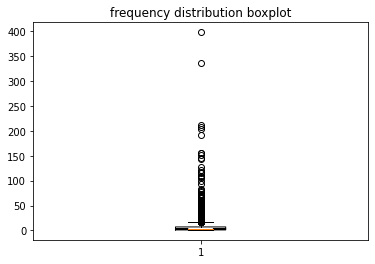

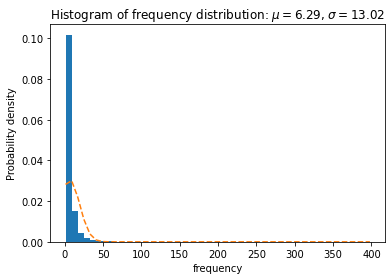

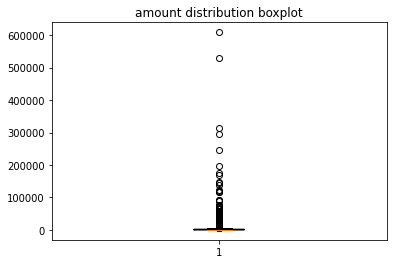

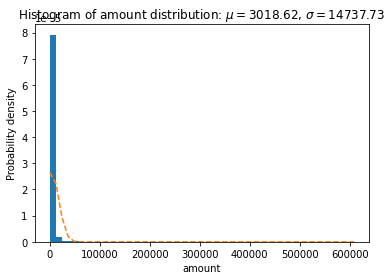

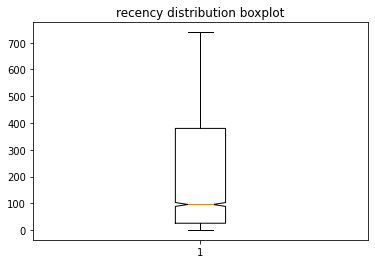

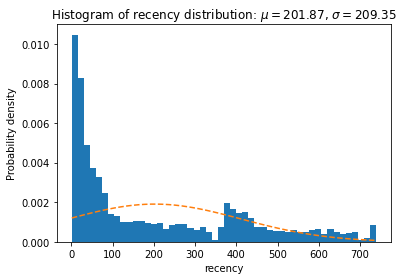

In [ ]:
# Визуализируем распределение каждой RFM-метрики
# Это поможет понять, есть ли выбросы и насколько данные нормально распределены
feature_columns = ['frequency', 'amount', 'recency']
for col_name in feature_columns:
    x = customers_df[col_name]
    plot_variable_distribution(x, col_name)

### Как видно на графиках выше, распределение интересующих нас переменных не похоже на нормальное. В датасете есть выбросы по давности, частоте покупок и сумме, потраченной клиентами.

### Хотя эти выбросы, вероятно, смещают распределение переменных от нормальности, мы должны сохранить эти наблюдения в датасете. Если мы избавимся от этих "выбросов", мы можем потерять ценную информацию о пользователях, которые приносят большую часть выручки.

### Вместо этого мы можем попробовать трансформировать распределение выбранных переменных. Это позволит использовать эти переменные для сегментации клиентов без опасений относительно ненормальности распределений.

**Ключевой принцип:** Выбросы в RFM-анализе часто представляют самых ценных клиентов — их нельзя просто удалить!

But first of all - let's double check whether variable samples are normal or not with Sharipo-Wilk, D’Agostino’s K^2 and Anderson-Darling statistical tests.

In [19]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

for col_name in feature_columns:
    
    print(f'Sharipo-Wilk test for {col_name}')
    stat, p = shapiro(customers_df[col_name])
    print('Statistics=%.3f, p=%.3f of %s distribution' % (stat, p, col_name))

    alpha = 0.05
    if p > alpha:
        print(f'Sample of {col_name} looks normal (fail to reject H0) with Sharipo-Wilk Test')
    else:
        print(f'Sample of {col_name} does not look Gaussian (reject H0) with Sharipo-Wilk Test \n\n')
        
    print(f'D’Agostino’s K^2 test for {col_name}')
    stat, p = normaltest(customers_df[col_name])
    print('Statistics=%.3f, p=%.3f of %s distribution' % (stat, p, col_name))

    alpha = 0.05
    if p > alpha:
        print(f'Sample of {col_name} looks normal (fail to reject H0) with D’Agostino’s K^2 Test')
    else:
        print(f'Sample of {col_name} does not look normal (reject H0) with D’Agostino’s K^2 Test \n\n')
        
    print(f'Anderson-Darling test for {col_name}')
    
    result = anderson(customers_df[col_name])
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0) with Anderson-Darling test \n\n' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0) with Anderson-Darling test \n\n' % (sl, cv))

Sharipo-Wilk test for frequency
Statistics=0.341, p=0.000 of frequency distribution
Sample of frequency does not look Gaussian (reject H0) with Sharipo-Wilk Test 


D’Agostino’s K^2 test for frequency
Statistics=10475.611, p=0.000 of frequency distribution
Sample of frequency does not look normal (reject H0) with D’Agostino’s K^2 Test 


Anderson-Darling test for frequency
Statistic: 945.011
15.000: 0.576, data does not look normal (reject H0) with Anderson-Darling test 


10.000: 0.656, data does not look normal (reject H0) with Anderson-Darling test 


5.000: 0.786, data does not look normal (reject H0) with Anderson-Darling test 


2.500: 0.917, data does not look normal (reject H0) with Anderson-Darling test 


1.000: 1.091, data does not look normal (reject H0) with Anderson-Darling test 


Sharipo-Wilk test for amount
Statistics=0.124, p=0.000 of amount distribution
Sample of amount does not look Gaussian (reject H0) with Sharipo-Wilk Test 


D’Agostino’s K^2 test for amount
Stat

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Как видно из результатов выше, все тесты на нормальность показывают, что мы имеем дело с ненормальными распределениями (p-value ≈ 0).

### Поэтому мы можем применить логарифмическое преобразование к нашим переменным, чтобы сохранить выбросы и получить распределение, более похожее на нормальное.

**Идея вдохновлена докладом Анатолия Карпова на конференции Matemarketing 2019.**

**Почему логарифм?** Логарифмическое преобразование "сжимает" большие значения и "растягивает" малые, что помогает нормализовать правоскошенные распределения (типичные для финансовых данных).

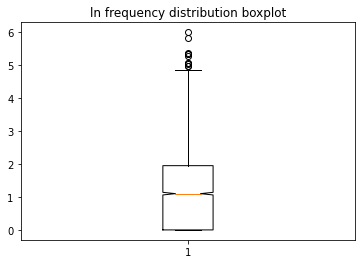

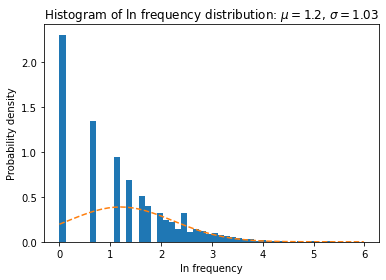

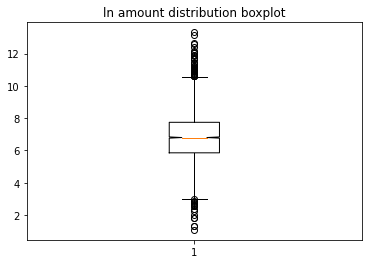

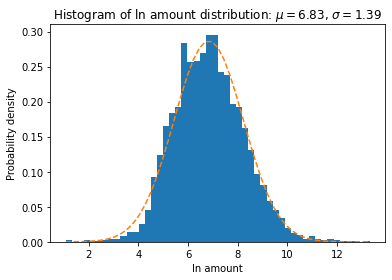

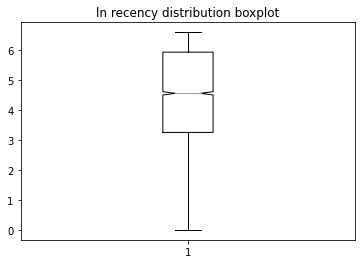

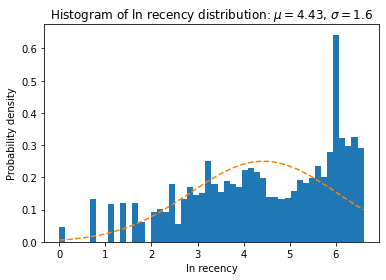

In [ ]:
# Применяем натуральный логарифм к каждой переменной и визуализируем результат
for col_name in feature_columns:
    x = customers_df[col_name]
    
    # Применяем ln-преобразование: ln(x) — натуральный логарифм
    ln_x = x.apply(lambda x: log(x))
    
    ln_col_name = 'ln ' + col_name
    
    # Строим графики для трансформированных данных
    plot_variable_distribution(ln_x, ln_col_name)

### Логарифмическое преобразование сделало распределения более похожими на нормальные!

### В качестве "бонуса" после log-преобразования все переменные теперь находятся примерно в одинаковом диапазоне абсолютных значений.

**Важно для K-Means:** Алгоритм K-Means чувствителен к масштабу признаков. Если одна переменная имеет значения от 1 до 100, а другая — от 1 до 100000, то вторая будет доминировать при расчёте расстояний. Log-преобразование частично решает эту проблему.

In [ ]:
# Создаём новые колонки с log-преобразованными значениями RFM
# r, f, m — это логарифмированные версии recency, frequency, amount
customers_df['r'] = customers_df['recency'].apply(lambda x: log(x))   # ln(давность)
customers_df['f'] = customers_df['frequency'].apply(lambda x: log(x)) # ln(частота)
customers_df['m'] = customers_df['amount'].apply(lambda x: log(x))    # ln(сумма)

In [ ]:
# Создаём рабочий датафрейм только с нужными колонками для кластеризации
# Customer ID — для идентификации, r, f, m — для кластеризации
use_df = customers_df[['Customer ID', 'r', 'f', 'm']]

## Теперь мы можем приступить к сегментации клиентов по давности, частоте и сумме покупок.

### Мы будем использовать алгоритм кластеризации K-Means. После этого проанализируем кластеры с помощью дерева решений для получения явной интерпретации правил (метод CART).

**План действий:**
1. Подберём оптимальное число кластеров (метод локтя + Silhouette Score)
2. Обучим K-Means с оптимальным k
3. Визуализируем кластеры
4. Интерпретируем кластеры с помощью дерева решений  

# Шаг 3. Сегментация клиентов с помощью K-Means

**K-Means** — это алгоритм кластеризации, который разбивает данные на k групп (кластеров) так, чтобы минимизировать внутрикластерную дисперсию. Каждая точка данных относится к кластеру с ближайшим центроидом.

In [ ]:
# Устанавливаем Customer ID как индекс датафрейма
# Это нужно, чтобы при кластеризации использовались только числовые признаки (r, f, m)
use_df.set_index('Customer ID', inplace=True)
use_df.head()

,r,f,m
Customer ID,,,
12346.0,5.786897,2.484907,11.258761
12347.0,1.098612,2.079442,8.636454
12348.0,4.330733,1.609438,7.610556
12349.0,2.944439,1.386294,8.395859
12350.0,5.739793,0.000000,5.812338


### Импортируем необходимые модули из библиотеки sklearn

**KMeans** — стандартная реализация алгоритма
**MiniBatchKMeans** — ускоренная версия для больших датасетов
**silhouette_score** — метрика качества кластеризации

In [ ]:
# Импортируем алгоритмы кластеризации и метрику качества
from sklearn.cluster import KMeans, MiniBatchKMeans  # Алгоритмы кластеризации
from sklearn.metrics import silhouette_score          # Метрика качества кластеризации

In [ ]:
# Проверяем размерность датафрейма: (количество клиентов, количество признаков)
use_df.shape

(5878, 3)

In [ ]:
%%time

# Подбираем оптимальное число кластеров методом локтя и Silhouette Score
# Перебираем k от 2 до 14 и сохраняем метрики

inertia = []  # Инерция (внутрикластерная сумма квадратов расстояний)
ss = []       # Silhouette Score (чем ближе к 1, тем лучше разделение кластеров)

for k in range(2, 15):
    %time kmeans = KMeans(n_clusters=k, random_state=1).fit(use_df)
    ss.append(silhouette_score(use_df, kmeans.labels_, metric='euclidean'))
    inertia.append(np.sqrt(kmeans.inertia_))  # Берём корень для лучшей визуализации
    
print('\n\nОБЩЕЕ ВРЕМЯ ВЫПОЛНЕНИЯ ЯЧЕЙКИ: ', )

CPU times: user 3.49 s, sys: 1.2 s, total: 4.69 s
Wall time: 1.23 s
CPU times: user 4.25 s, sys: 1.36 s, total: 5.61 s
Wall time: 1.44 s
CPU times: user 4.17 s, sys: 1.28 s, total: 5.45 s
Wall time: 1.39 s
CPU times: user 4.07 s, sys: 1.39 s, total: 5.46 s
Wall time: 1.4 s
CPU times: user 4.53 s, sys: 1.14 s, total: 5.67 s
Wall time: 1.44 s
CPU times: user 4.62 s, sys: 1.33 s, total: 5.95 s
Wall time: 1.55 s
CPU times: user 4.93 s, sys: 1.37 s, total: 6.3 s
Wall time: 1.61 s
CPU times: user 30.4 s, sys: 6.28 s, total: 36.7 s
Wall time: 9.26 s
CPU times: user 34.4 s, sys: 6.92 s, total: 41.3 s
Wall time: 10.6 s
CPU times: user 35.6 s, sys: 7.29 s, total: 42.9 s
Wall time: 10.8 s
CPU times: user 28.1 s, sys: 5.7 s, total: 33.8 s
Wall time: 8.51 s
CPU times: user 35.5 s, sys: 6.97 s, total: 42.5 s
Wall time: 10.9 s
CPU times: user 44.8 s, sys: 9.06 s, total: 53.9 s
Wall time: 13.6 s


TOTAL CELL RUNTIME: 
CPU times: user 4min 10s, sys: 56.1 s, total: 5min 6s
Wall time: 1min 23s


Text(0, 0.5, '$J(C_k)$')

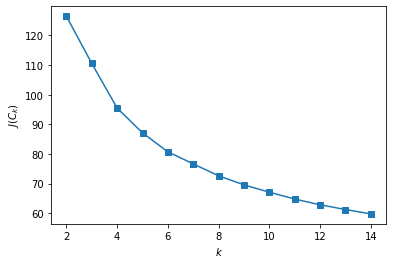

In [ ]:
# Строим график "локтя" (Elbow Method)
# Ищем точку перегиба, после которой уменьшение инерции становится незначительным
plt.plot(range(2, 15), inertia, marker='s')
plt.xlabel('Количество кластеров $k$')
plt.ylabel('Инерция $J(C_k)$')
plt.title('Метод локтя для определения оптимального k')

#### Оптимальное число кластеров — 4 согласно "правилу локтя". После k=4 изменение инерции становится менее значительным, чем до k=4.

**Интерпретация:** "Локоть" на графике — это точка, где добавление новых кластеров перестаёт существенно улучшать качество кластеризации.

Text(0, 0.5, 'silhouette_score')

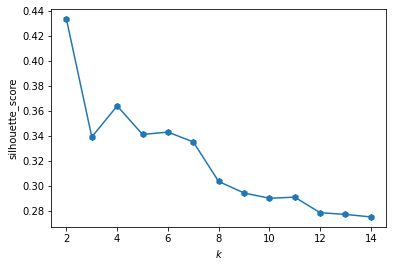

In [ ]:
# Строим график Silhouette Score для каждого k
# Silhouette Score показывает, насколько хорошо объекты "вписываются" в свои кластеры
plt.plot(range(2, 15), ss, marker='h')
plt.xlabel('Количество кластеров $k$')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта для разного числа кластеров')

#### Коэффициент силуэта также подтверждает, что 4 — оптимальное число кластеров (локальный максимум на графике).

#### Давайте также сравним скорость и качество MiniBatchKMeans со стандартным KMeans из scikit-learn.

**MiniBatchKMeans** использует мини-батчи (подвыборки) данных для обновления центроидов, что значительно ускоряет работу на больших датасетах.

In [ ]:
%%time
# Тот же процесс, но с MiniBatchKMeans — сравним скорость работы
inertia_minib = []  # Инерция для MiniBatch
ss_minib = []       # Silhouette Score для MiniBatch

for k in range(2, 15):
    %time kmeans_mini = MiniBatchKMeans(n_clusters=k, random_state=1).fit(use_df)
    ss_minib.append(silhouette_score(use_df, kmeans_mini.labels_, metric='euclidean'))
    inertia_minib.append(np.sqrt(kmeans_mini.inertia_))
    
print('\n\nОБЩЕЕ ВРЕМЯ ВЫПОЛНЕНИЯ ЯЧЕЙКИ: ', )

CPU times: user 63.6 ms, sys: 16.5 ms, total: 80.1 ms
Wall time: 82 ms
CPU times: user 45.2 ms, sys: 4.8 ms, total: 50 ms
Wall time: 28.8 ms
CPU times: user 64.9 ms, sys: 2.99 ms, total: 67.9 ms
Wall time: 45.6 ms
CPU times: user 71 ms, sys: 4.81 ms, total: 75.8 ms
Wall time: 53.3 ms
CPU times: user 76.3 ms, sys: 5.09 ms, total: 81.4 ms
Wall time: 57.9 ms
CPU times: user 98.8 ms, sys: 5.94 ms, total: 105 ms
Wall time: 80.4 ms
CPU times: user 120 ms, sys: 1.1 ms, total: 122 ms
Wall time: 96.4 ms
CPU times: user 81.3 ms, sys: 6.06 ms, total: 87.3 ms
Wall time: 61 ms
CPU times: user 61.7 ms, sys: 5.94 ms, total: 67.7 ms
Wall time: 40.6 ms
CPU times: user 66.9 ms, sys: 1.98 ms, total: 68.9 ms
Wall time: 41.3 ms
CPU times: user 69.5 ms, sys: 1.9 ms, total: 71.4 ms
Wall time: 42.7 ms
CPU times: user 72.7 ms, sys: 4.95 ms, total: 77.7 ms
Wall time: 46.6 ms
CPU times: user 86.7 ms, sys: 4.71 ms, total: 91.4 ms
Wall time: 57.7 ms


TOTAL CELL RUNTIME: 
CPU times: user 12 s, sys: 5.24 s, total: 

Text(0.5, 1.0, 'Intertia')

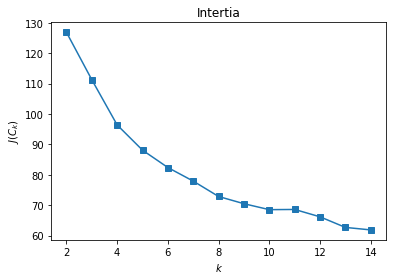

In [ ]:
# График инерции для MiniBatchKMeans
plt.plot(range(2, 15), inertia_minib, marker='s')
plt.xlabel('Количество кластеров $k$')
plt.ylabel('Инерция $J(C_k)$')
plt.title('Инерция (MiniBatchKMeans)')

Text(0.5, 1.0, 'Silhouette score')

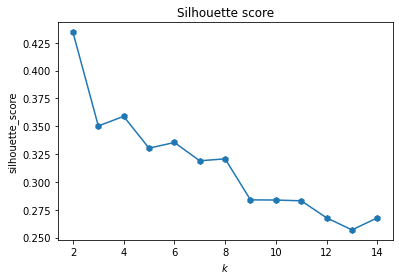

In [ ]:
# График Silhouette Score для MiniBatchKMeans
plt.plot(range(2, 15), ss_minib, marker='h')
plt.xlabel('Количество кластеров $k$')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта (MiniBatchKMeans)')

#### Мы можем получить аналогичные выводы из запусков алгоритмов MiniBatchKMeans и KMeans. Тем не менее, наблюдается значительное улучшение времени выполнения при использовании MiniBatchKMeans по сравнению со стандартным KMeans (17.2 секунды против 4 минут 49 секунд общего времени выполнения ячейки).

#### Таким образом, мы можем использовать алгоритм MiniBatchKMeans на больших датасетах (документация scikit-learn рекомендует n >= 10k наблюдений) для поиска оптимального числа кластеров, экономя время.

**Вывод:** MiniBatchKMeans — отличный инструмент для предварительного анализа и подбора гиперпараметров на больших данных.

Однако для получения финальной кластеризации мы используем стандартный KMeans для обеспечения стабильности результатов. На одной итерации разница в скорости между MiniBatchKMeans и стандартным KMeans не будет столь значительной, как мы видели при множественных итерациях.

**Почему стандартный KMeans для финального результата?** Он использует все данные для расчёта центроидов, что даёт более точный и воспроизводимый результат.

In [ ]:
# Обучаем финальную модель K-Means с оптимальным числом кластеров (k=4)
c = KMeans(n_clusters=4, random_state=42)
use_df['cluster'] = c.fit_predict(use_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Сдвигаем номера кластеров с 0-3 на 1-4 для более понятной нумерации
use_df['cluster'] = use_df['cluster'] + 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Преобразуем тип кластера в целое число
use_df['cluster'] = use_df['cluster'].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Распределение клиентов по кластерам почти равномерное, без значительных перекосов в сторону какого-либо кластера.

Это хороший знак — значит, кластеризация выявила естественные группы клиентов, а не просто разделила их на "большую" и "маленькую" группы.

### Давайте изучим распределение кластеров с помощью базовых визуализаций

Визуализация поможет понять, как кластеры разделяются в пространстве признаков и какие закономерности можно выявить.

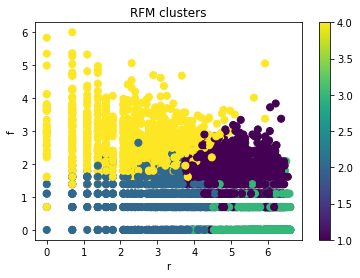

In [ ]:
# Визуализация кластеров в пространстве (Recency, Frequency)
# Каждый цвет представляет отдельный кластер
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(use_df['r'], use_df['f'], c=use_df['cluster'], s=50)
                    
ax.set_title('RFM кластеры: Recency vs Frequency')
ax.set_xlabel('r (ln давности)')
ax.set_ylabel('f (ln частоты)')
plt.colorbar(scatter)

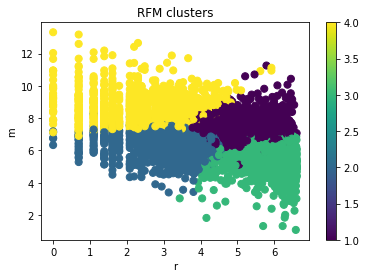

In [ ]:
# Визуализация кластеров в пространстве (Recency, Monetary)
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(use_df['r'], use_df['m'], c=use_df['cluster'], s=50)
                    
ax.set_title('RFM кластеры: Recency vs Monetary')
ax.set_xlabel('r (ln давности)')
ax.set_ylabel('m (ln суммы)')
plt.colorbar(scatter)

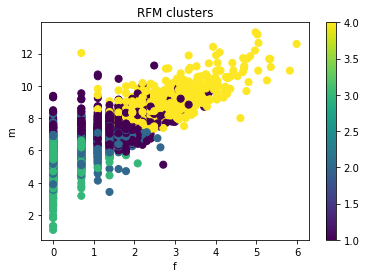

In [ ]:
# Визуализация кластеров в пространстве (Frequency, Monetary)
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(use_df['f'], use_df['m'], c=use_df['cluster'], s=50)
                    
ax.set_title('RFM кластеры: Frequency vs Monetary')
ax.set_xlabel('f (ln частоты)')
ax.set_ylabel('m (ln суммы)')
plt.colorbar(scatter)

### Теперь попробуем визуализировать взаимосвязь между кластерами, r, f и m в одной матрице диаграмм рассеяния, чтобы получить полную картину:

**Pairplot** показывает все попарные отношения между признаками и позволяет увидеть структуру кластеров в многомерном пространстве. 

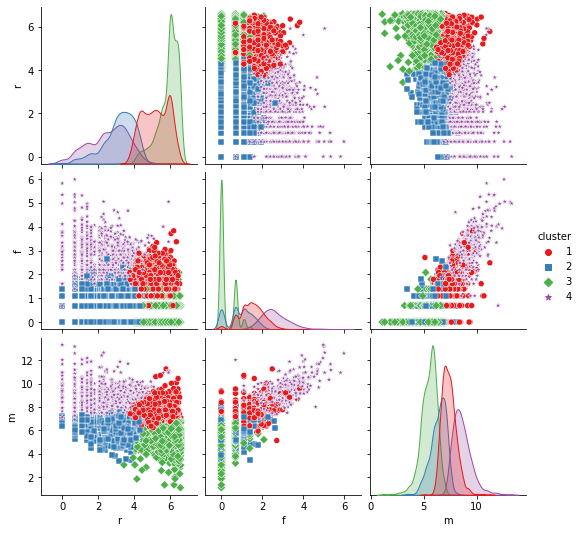

In [ ]:
# Строим матрицу диаграмм рассеяния для всех пар признаков
# Каждый кластер отображается своим цветом и маркером
sns.pairplot(use_df, hue="cluster", markers=["o", "s", "D", "*"], 
             palette=sns.color_palette('Set1', n_colors=4))

## Высокоуровневая интерпретация каждого кластера:

### Кластер 4: низкая давность, высокая частота, высокая денежная ценность
- Покупали недавно, с высокой частотой и на большие суммы
- **Самые лояльные и ценные клиенты** — "звёзды" бизнеса
- **Стратегия:** Поддерживать лояльность, предлагать VIP-программы

### Кластер 1: высокая давность, высокая частота, высокая денежная ценность
- НЕ покупали недавно, но раньше покупали часто и на большие суммы
- **Клиенты "на грани ухода"** — нуждаются в реактивации
- **Стратегия:** Специальные предложения, персональные скидки, напоминания

### Кластер 3: высокая давность, низкая частота, низкая денежная ценность
- НЕ покупали недавно, покупали редко и на малые суммы
- **Вероятно, клиенты, которые купили один раз и ушли** (churned)
- **Стратегия:** Попытки вернуть через промо-акции, но приоритет ниже

### Кластер 2: низкая давность, низкая частота, низкая денежная ценность
- Покупали недавно, но редко и на малые суммы
- **Новые клиенты** — только что сделали первые заказы
- **Стратегия:** Программы для новых клиентов, стимулирование повторных покупок

### Чтобы получить более явную интерпретацию того, как сегменты клиентов различаются друг от друга, мы обучим классификатор дерева решений. Это позволит нам увидеть границы между сегментами в виде понятных правил.

# Шаг 4. Получение явной интерпретации кластеров

**Дерево решений (Decision Tree)** поможет нам понять, какие именно значения RFM-метрик определяют принадлежность к каждому кластеру. Это даст нам чёткие правила для классификации новых клиентов.

In [ ]:
# Возвращаем Customer ID из индекса в колонку для последующего объединения
use_df = use_df.reset_index()

Объединяем информацию о кластере клиента с исходными данными.

Это позволит нам использовать исходные (не логарифмированные) значения RFM для обучения дерева решений, что сделает интерпретацию более понятной.

In [ ]:
# Объединяем датафрейм с клиентами и их RFM-метриками с информацией о кластерах
final_df = customers_df.merge(use_df[['Customer ID', 'cluster']], how='inner', on='Customer ID')

In [ ]:
# Удаляем логарифмированные колонки — они больше не нужны
# Для интерпретации будем использовать исходные значения frequency, amount, recency
final_df.drop(columns=['r', 'f', 'm'], inplace=True)

In [ ]:
# Просматриваем финальный датафрейм с кластерами
final_df.head()

,Customer ID,frequency,amount,recency,cluster
0,12346.0,12,77556.46,326,1
1,12347.0,8,5633.32,3,4
2,12348.0,5,2019.40,76,1
3,12349.0,4,4428.69,19,4
4,12350.0,1,334.40,311,3


In [ ]:
# Импортируем необходимые модули для обучения дерева решений
from sklearn.tree import DecisionTreeClassifier  # Классификатор дерева решений
from sklearn.model_selection import train_test_split  # Разделение на обучающую и тестовую выборки
from sklearn import metrics  # Метрики для оценки качества модели

In [ ]:
# Подготавливаем данные для обучения дерева решений
# X — признаки (RFM-метрики), y — целевая переменная (кластер)
print(feature_columns)
X = final_df[feature_columns]
y = final_df['cluster']

['frequency', 'amount', 'recency']


In [ ]:
# Разделяем данные на обучающую (80%) и тестовую (20%) выборки
# random_state=1 для воспроизводимости результатов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [ ]:
# Обучаем дерево решений с максимальной глубиной 3
# criterion='entropy' — используем энтропию для выбора разбиений
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
clf_tree = clf_tree.fit(X_train, y_train)

In [ ]:
# Делаем предсказания на тестовой выборке
y_pred = clf_tree.predict(X_test)

In [ ]:
# Оцениваем точность модели (доля правильно предсказанных кластеров)
print("Точность модели: ", metrics.accuracy_score(y_test, y_pred))

Accuracy score:  0.8869047619047619


Давайте визуализируем обученное дерево решений

Визуализация дерева поможет понять логику принятия решений и увидеть, какие правила определяют принадлежность к каждому кластеру.

In [ ]:
# Импортируем библиотеки для визуализации дерева решений
import io
from io import StringIO
from sklearn.tree import export_graphviz  # Экспорт дерева в формат DOT
from IPython.display import Image         # Отображение изображений в Jupyter
import pydotplus                         # Работа с графами
import graphviz                         # Визуализация графов
from pydot import graph_from_dot_data    # Преобразование DOT в граф

In [ ]:
# Названия кластеров для визуализации дерева
cluster_names = ['1', '2', '3', '4']

In [ ]:
def plot_decision_tree(clf, feature_cols, class_names):
    """
    Функция для визуализации дерева решений.
    
    Параметры:
    clf — обученный классификатор дерева решений
    feature_cols — названия признаков
    class_names — названия классов (кластеров)
    """
    dot_data = StringIO()
    # Экспортируем дерево в формат DOT
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,      # Заливка и скругление узлов
                    special_characters=True,        # Поддержка специальных символов
                    feature_names=feature_cols,    # Названия признаков
                    class_names=class_names)       # Названия классов
    # Преобразуем DOT в граф и создаём PNG изображение
    (graph, ) = graph_from_dot_data(dot_data.getvalue())
    
    return Image(graph.create_png())

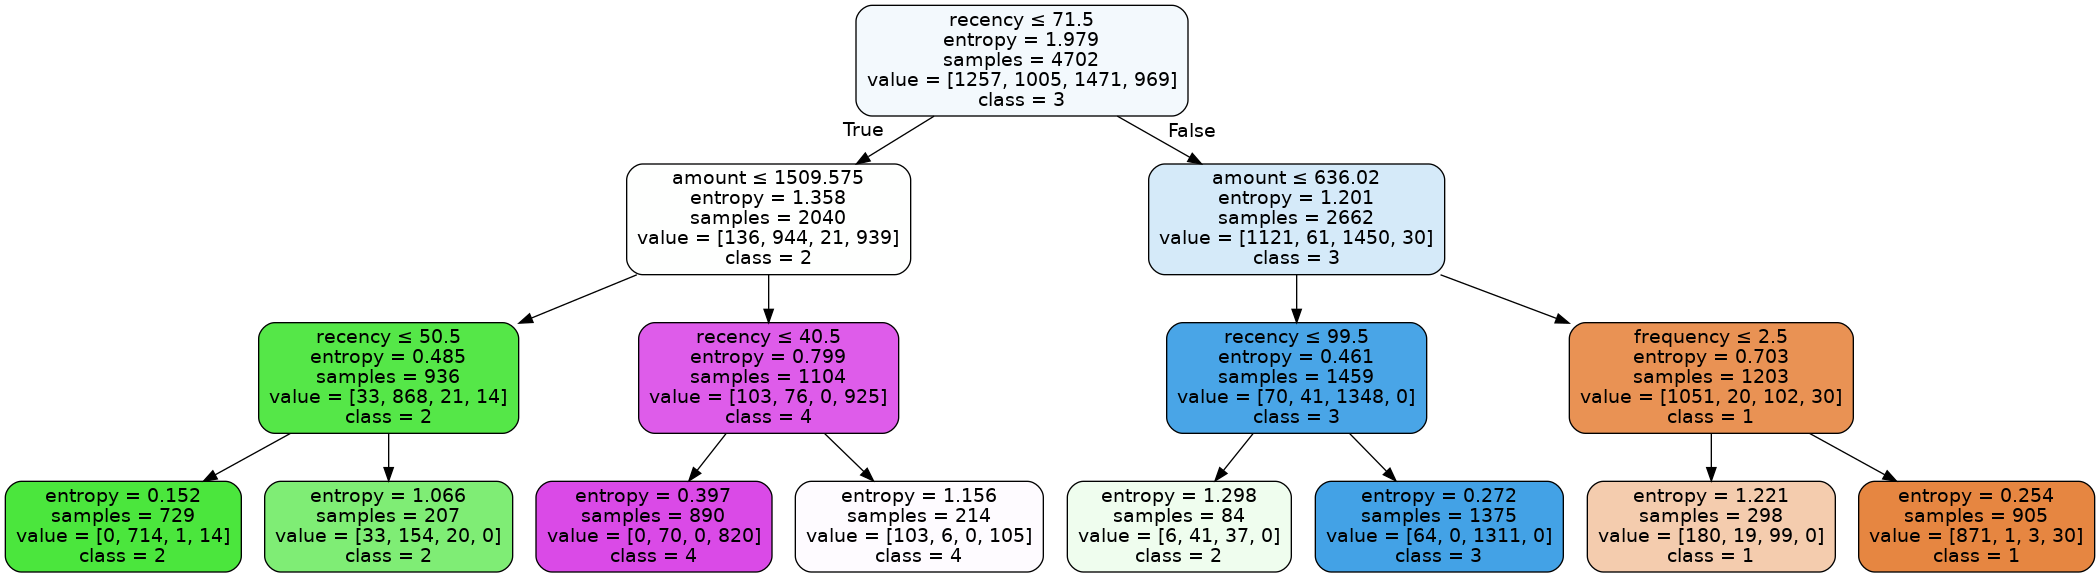

In [ ]:
# Визуализируем дерево решений с глубиной 3
plot_decision_tree(clf_tree, feature_columns, cluster_names)

### Можно обоснованно ограничить глубину дерева решений до 2, так как на глубине = 3 нет правил, которые можно применить без конфликта с предыдущими правилами с точки зрения прироста энтропии. Кроме того, шаг на глубине 3 при разделении клиентов кластера 3 может выглядеть как переобучение.

### Давайте теперь обучим новое дерево решений с max_depth = 2

**Почему глубина 2?** Более простое дерево легче интерпретировать и оно менее склонно к переобучению, при этом точность может даже улучшиться.

In [ ]:
# Обучаем дерево с глубиной 2
clf_2 = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=17)
clf_2 = clf_2.fit(X_train, y_train)
y_pred = clf_2.predict(X_test)
print("Точность модели: ", metrics.accuracy_score(y_test, y_pred))

Accuracy score:  0.891156462585034


### С max_depth = 2 мы даже получили немного более высокую точность предсказаний!

Это подтверждает, что более простое дерево не только легче интерпретировать, но и может работать лучше.

### Давайте визуализируем дерево с max_depth = 2

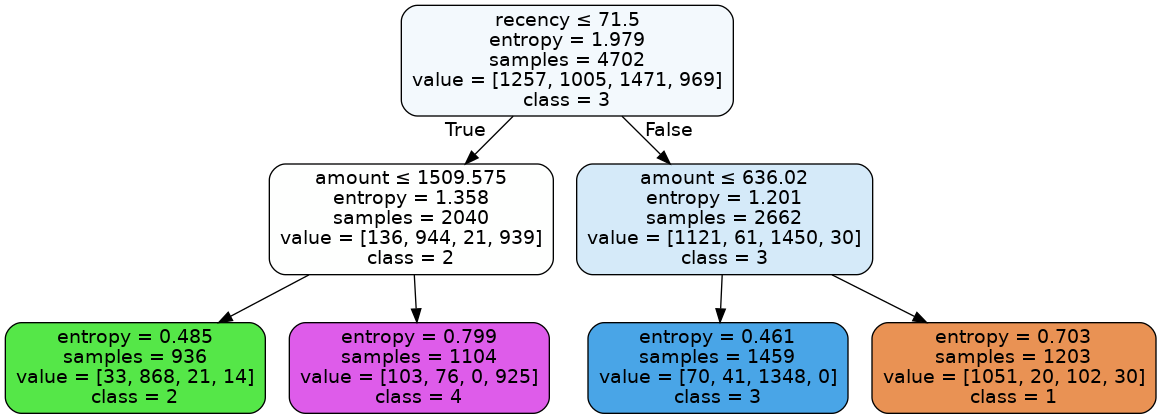

In [ ]:
# Визуализируем упрощённое дерево решений (глубина 2)
plot_decision_tree(clf_2, feature_columns, cluster_names)

## Также из того, как дерево решений обучило правила, мы видим, что частота (frequency) не используется, потому что она, вероятно, коррелирует с потраченной суммой (amount). Это также видно на графиках выше с 4 кластерами. Нет кластера с высокой частотой и низкой суммой или низкой частотой и высокой суммой.

## Этот момент является частью критики RFM-методологии. Альтернативным решением может быть использование средней суммы, потраченной за один счёт, вместо общей суммы, потраченной клиентом.

**Важное наблюдение:** Частота и сумма покупок часто сильно коррелируют — клиенты, которые покупают часто, обычно тратят больше. Это ограничение классической RFM-методологии.

**Большая благодарность блогу проекта https://mljar.com/ за предоставление полезных пользовательских функций для извлечения правил из алгоритма дерева решений!**

In [ ]:
# Функция для извлечения правил из дерева решений в читаемом формате
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    """
    Извлекает правила из дерева решений в виде читаемых текстовых правил.
    
    Параметры:
    tree — обученное дерево решений
    feature_names — названия признаков
    class_names — названия классов
    
    Возвращает:
    Список правил в формате "if условие then класс"
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    # Рекурсивная функция для обхода дерева
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            # Листовой узел — добавляем путь
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # Сортируем пути по количеству образцов (от большего к меньшему)
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    # Формируем правила в читаемом формате
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
# Извлекаем правила из дерева решений
rule_values = get_rules(clf_2, feature_columns, cluster_names)

In [ ]:
# Выводим правила классификации
rule_values

['if (recency > 71.5) and (amount <= 636.02) then class: 3 (proba: 92.39%) | based on 1,459 samples',
 'if (recency > 71.5) and (amount > 636.02) then class: 1 (proba: 87.36%) | based on 1,203 samples',
 'if (recency <= 71.5) and (amount > 1509.575) then class: 4 (proba: 83.79%) | based on 1,104 samples',
 'if (recency <= 71.5) and (amount <= 1509.575) then class: 2 (proba: 92.74%) | based on 936 samples']

Из сформулированных выше правил мы можем разделить клиентов на сегменты.

Теперь у нас есть чёткие пороговые значения для классификации клиентов по сегментам на основе их RFM-метрик. 

In [ ]:
# Определяем условия для сегментации на основе правил дерева решений
# Пороговые значения получены из дерева решений
conditions = [
    (final_df['recency'] > 71.5) & (final_df['amount'] <= 636.02),      # Высокая давность, низкая сумма
    (final_df['recency'] > 71.5) & (final_df['amount'] > 636.02),       # Высокая давность, высокая сумма
    (final_df['recency'] <= 71.5) & (final_df['amount'] > 1509.575),    # Низкая давность, высокая сумма
    (final_df['recency'] <= 71.5) & (final_df['amount'] <= 1509.575)    # Низкая давность, низкая сумма
]

# Названия сегментов
choices = ['высокая давность - низкая сумма', 'высокая давность - высокая сумма', 
           'низкая давность - высокая сумма', 'низкая давность - низкая сумма']

In [ ]:
# Присваиваем сегменты клиентам на основе условий
final_df['segment'] = np.select(conditions, choices, default='other')

In [ ]:
# Агрегируем статистику по каждому сегменту
agg_stats_df = final_df.groupby('segment').agg(
    median_recency = ('recency', 'median'),      # Медианная давность
    median_frequency = ('frequency', 'median'),  # Медианная частота
    median_amount = ('amount', 'median'),        # Медианная сумма
    customers = ('Customer ID', 'nunique')       # Количество клиентов
).reset_index()

In [ ]:
# Вычисляем процент клиентов в каждом сегменте
agg_stats_df['% процент клиентов'] = round(
    agg_stats_df['customers'] / agg_stats_df['customers'].sum() * 100, 1)

In [ ]:
# Просматриваем агрегированную статистику по сегментам
agg_stats_df

,segment,median_recency,median_frequency,median_amount,customers,% cutomers percentage
0,high recency - high amount,219.0,4,1380.815,1468,25.0
1,high recency - low amount,402.5,1,281.510,1830,31.1
2,low recency - high amount,18.0,11,4007.540,1391,23.7
3,low recency - low amount,26.0,3,662.550,1189,20.2


# Шаг 5: Выводы и первые инсайты

### Некоторые инсайты о давности покупок клиентов

Согласно данным, около 57% клиентов находятся в сегментах с "высокой давностью". Это может быть индикатором необходимости улучшения удержания покупателей и внедрения программы лояльности. Бизнесу следует пересмотреть стратегию в каналах привлечения, которые приносят много клиентов, остающихся в сегменте "высокая давность - низкая сумма".

Особое внимание при реактивации следует уделить сегменту "высокая давность - высокая сумма", так как это более ценные клиенты для бизнеса.

Как мы выяснили из правил, мы также можем отслеживать процент пользователей, которые совершили покупку менее 71.5 дней назад. Возможным KPI улучшений в этой области бизнеса может быть процент клиентов, совершивших покупку менее 71.5 дней назад. Чем больше этот процент — тем лучше.

В то же время должен быть механизм предотвращения перехода клиентов из сегментов с низкой давностью в сегменты с высокой давностью. Может быть выгодно создавать специальные предложения для клиентов, которые близки к превращению в клиентов с "высокой давностью". В частности, если клиент не покупал ничего в течение 60-70 дней, стоит попробовать дать такому клиенту специальное предложение.

**Ключевые рекомендации:**
1. Внедрить программу лояльности для удержания активных клиентов
2. Создать систему автоматических напоминаний для клиентов, не покупавших 60-70 дней
3. Пересмотреть каналы привлечения, которые приносят "некачественных" клиентов

In [ ]:
# Агрегируем общую статистику по сегментам (суммы, а не медианы)
total_stats_df = final_df.groupby('segment').agg(
    total_frequency = ('frequency', 'sum'),  # Общее количество заказов
    total_amount = ('amount', 'sum')         # Общая сумма покупок
).reset_index()

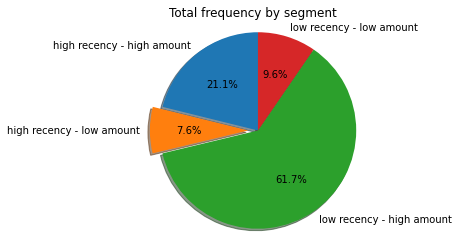

In [ ]:
# Визуализируем распределение общего количества заказов по сегментам
labels = total_stats_df['segment']
sizes = total_stats_df['total_frequency']
explode = (0, 0.1, 0, 0)  # Выделяем 2-й сегмент (высокая давность - высокая сумма)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Равное соотношение сторон для круглой диаграммы
ax1.set_title('Общее количество заказов по сегментам')

plt.show()

61.7% всех заказов совершено клиентами сегмента "низкая давность - высокая сумма"

Это подтверждает, что самые активные и ценные клиенты генерируют большую часть транзакций.

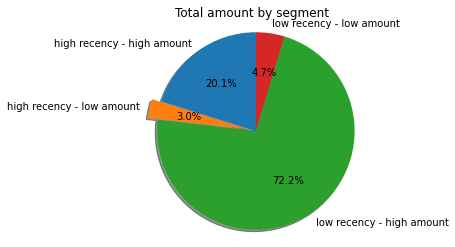

In [ ]:
# Визуализируем распределение общей суммы покупок по сегментам
labels = total_stats_df['segment']
sizes = total_stats_df['total_amount']
explode = (0, 0.1, 0, 0)  # Выделяем 2-й сегмент

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Равное соотношение сторон для круглой диаграммы
ax1.set_title('Общая сумма покупок по сегментам')

plt.show()

72.2% всей суммы потрачено клиентами сегмента "низкая давность - высокая сумма"

**Критический инсайт:** Небольшая группа самых активных клиентов генерирует более 70% выручки! Это классический пример правила Парето (80/20).

In [ ]:
# Сохраняем результаты сегментации в CSV файл для дальнейшего использования
final_df.to_csv('./customer_segments.csv', index=False)

### Дальнейшие ноутбуки с использованием сегментов клиентов будут включать:

1. **Анализ различных сегментов клиентов** с точки зрения географии и времени покупок
   - Где живут самые ценные клиенты?
   - В какое время они предпочитают покупать?
   
2. **Анализ отменённых заказов** — может быть полезно сравнить сегменты с точки зрения отмен
   - Какие сегменты чаще отменяют заказы?
   - Есть ли закономерности в отменах?

**Потенциальные направления анализа:**
- Прогнозирование оттока клиентов (churn prediction)
- Персонализация маркетинговых кампаний
- Оптимизация каналов привлечения

## Ссылки и ресурсы, использованные в этом ноутбуке:

1. [Статья Mindbox о создании похожего решения](https://habr.com/ru/company/mindbox/blog/423463/) — как Mindbox создали похожее решение для своих клиентов
2. [Ещё одна статья Mindbox](https://habr.com/ru/company/mindbox/blog/420915/) — дополнительный материал от Mindbox
3. [Stack Exchange о decision tree для кластеризации](https://stats.stackexchange.com/questions/102984/is-there-a-decision-tree-like-algorithm-for-unsupervised-clustering) — общий подход к использованию деревьев решений для интерпретации кластеров
4. [Stack Overflow о извлечении правил из дерева](https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree) — как извлекать правила из дерева решений scikit-learn
5. [ODS.ai о деревьях решений](https://habr.com/ru/company/ods/blog/322534/#vvedenie) — введение в деревья решений от Open Data Science
6. [ODS.ai о выборе числа кластеров для K-Means](https://habr.com/ru/company/ods/blog/325654/#vybor-chisla-klasterov-dlya-kmeans) — как выбирать оптимальное число кластеров
7. [MLJAR о извлечении правил из дерева](https://mljar.com/blog/extract-rules-decision-tree/) — отличный обзор того, как можно извлекать правила из классификатора дерева решений в читаемом текстовом формате

#### Если вы дошли до этого места, большое спасибо! Пожалуйста, поставьте лайк ноутбуку, если он вам понравился, и оставьте своё мнение в разделе комментариев.

**Надеемся, этот анализ был полезен для понимания RFM-методологии и её применения на практике!**